### 窗口大小为2的skip_gram模型结构
##### Embedding     
W1(len_of_co_matrix,hyperparams1),X(batch_size,1)  →  Y1(batch_size,hyperparams1)]    
##### Embeddingdot1(left1/2/3/4 target 需要都为正或都为负)
W2(hyperparams1,len_of_co_matrix),Y1(batch_size,hyperparams1),left1 target(batch_size,1)→Y2_1(batch_size,1)
##### Embeddingdot2
W4(hyperparams1,len_of_co_matrix),Y1(batch_size,hyperparams1),left2 target(batch_size,1)→Y2_2(batch_size,1)
##### Embeddingdot3
W3(hyperparams1,len_of_co_matrix),Y1(batch_size,hyperparams1),right1 target(batch_size,1)→Y2_3(batch_size,1)
##### Embeddingdot4
W5(hyperparams1,len_of_co_matrix),Y1(batch_size,hyperparams1),right2 target(batch_size,1)→Y2_4(batch_size,1)
##### Sigmoid1
Y2_1（batch_size,1）→S1（batch_size,1）
##### Sigmoid2
Y2_2（batch_size,1）→S2（batch_size,1）
##### Sigmoid3
Y2_3（batch_size,1）→S3（batch_size,1）
##### Sigmoid4
Y2_4（batch_size,1）→S4（batch_size,1）
##### CrossEntropyLoss1
S1（batch_size,1）,postive label/negative label（batch_size,1）→L1（1）
##### CrossEntropyLoss2
S2（batch_size,1）,postive label/negative label（batch_size,1）→L2（1）
##### CrossEntropyLoss3
S3（batch_size,1）,postive label/negative label（batch_size,1）→L3（1）
##### CrossEntropyLoss4
S4（batch_size,1）,postive label/negative label（batch_size,1）→L4（1）

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
class Embedding():
    '''
    根据单词在语义库中的id，返回权重列表中对应的权重数据，不带偏置
    '''
    def __init__(self,W):
        
        self.params = {}
        self.params['W'] = W
        self.grads = {}
        
    def forward(self,X):
        
        #为了计算方便，X代表的数据集需要以单词的id形式表达，而不是one hot形式，如[0,3,2,4,2,1]，而不是[[0,0,0,0,1],[0,0,1,0,0]……]。
        
        if int(max(X)) > 1 :
            X = [int(i) for i in X]
            self.params['X'] = X
            return self.params['W'][X]
        
        else:
            print('X代表的数据集需要以单词的id形式表达')

    def backward(self,dout):
        
        #生成导数之前先归零，避免循环过程中导数不断叠加
        self.grads['W'] = np.zeros_like(self.params['W'])

        #dout中的第n行数据，乘以1之后，是W中第data_id行的导数
        for n,data_id in enumerate(self.params['X']):
            
            self.grads['W'][data_id] += dout[n]*1
        
        return

In [44]:
class EmbeddingDot():
    
    '''
    根据目标在语义库中的id，返回权重列表中对应的数据列，然后与对应的中间层神经元相乘后得到结果
    '''
    
    def __init__(self,W):
        
        #W表示的是输出层权重矩阵
        
        self.params = {}
        self.params['W'] = W
        self.grads = {}
        self.grads['W'] = np.zeros_like(self.params['W'])
        
    def forward(self,X,y_id):
        
        #X代表的是CBOW模型中间层神经元的数值，y_id表示的是对应目标值的id，数据集需要以id形式表达成list，而不是one hot形式，如[0,3,2,4,2,1]，而不是[[0,0,0,0,1],[0,0,1,0,0]……]。
        if len(y_id) != 0 and len(X) != 0:

            y_id = [int(i) for i in y_id]
            self.params['X'] = X
            self.y = y_id
            
            return np.sum(self.params['W'].T[y_id]*X,axis=1)
        
        else:
            print('数据集需要以列表的格式填入目标单词的id')

    def backward(self,dout):
        
        #生成导数之前先归零，避免循环过程中导数不断叠加
        self.grads['X'] = np.zeros_like(self.params['X'])
        self.grads['W'] = np.zeros_like(self.params['W'])
        
        #X的导数
        self.grads['X'] = dout.reshape(-1,1).repeat(len(self.params['W']),axis=1)*self.params['W'].T[self.y]
        
        #W的导数绝大部分是0，所以先把输入数据对应的权重列先找出来，然后再更新对应的权重，跟输入数据无权的权重不更新，还是0
        for n,target_id in enumerate(self.y):
            self.grads['W'][:,target_id] += dout[n] * (self.params['X'][n]).T
        
        return self.grads['X']
        

In [45]:
class Sigmoid():
    
    '''
    一个sigmoid层，为了防止正向传播数值太小结果为零的情况，默认添加一个1e-8的微小数
    '''
    
    def __init__(self,eps=1e-8):
        
        self.eps = eps
        self.params = {}
        self.grads = {}
    
    def forward(self,X):
        
        y = 1/(1+np.exp(-1*X)) + self.eps
        
        self.y = y
                
        return y
    
    def backward(self,dout):
        
        self.grads['X'] = dout*self.y*(1-self.y)
        
        return self.grads['X']
            

In [46]:
class CrossEntropyLoss():
    
    '''
    交叉熵损失函数
    '''
    
    def __init__(self):
        
        self.params = {}
        self.grads = {}
        
    def forward(self,X,y):
        
        total_loss = np.sum(-y*np.log(X)) 
        self.y = y
        self.params['X'] = X
        
        return total_loss
    
    def backward(self,dout=1):
        
        self.grads['X'] = (-1/self.params['X'])*self.y*dout
        
        return self.grads['X']
        

In [47]:
class DataPreproess():
    
    '''
    根据corpus,word_to_id,id_to_word三个数据，生成可供skip—gram模型训练的完整数据，当不提供原始数据时，默认使用ptb数据集
    '''
    
    def __init__(self,window_size=2,data_format = 'id',negative_sampling_size=4,negative_sampling_params =0.75,module= 'cbow'):
        
        '''
        data_format = 'id' or 'one_hot'
        module= 'skip_gram' or 'cbow'
        '''
        
        self.window_size = window_size
        self.data_format = data_format
        self.negative_sampling_size = negative_sampling_size
        self.negative_sampling_params = negative_sampling_params
        self.module = module
        
        self.corpus = None
        self.word_to_id = None
        self.id_to_word = None
        self.co_matrix = None
        
        self.train_feat = None
        self.train_postive_target = None
        self.train_negative_target = None
#         self.train_postive_target_with_label = None
#         self.train_negative_target_with_label = None
        self.train_data = None
        
    def get_ptb_data(self):
        
        '''
        需要将当前文件与ptb文件夹放在同一目录下使用，以获得数据集的相关数据
        '''
        
        #获取corpus,word_to_id,id_to_word数据
        import sys
        import os
        sys.path.append('..')
        import pickle

        dataset_dir = os.path.abspath('')
        vocab_path = dataset_dir + '\\ptb' + '\\ptb.vocab.pkl'
        save_path = dataset_dir + '\\ptb' + '\\ptb.train.npy'

        with open(vocab_path, 'rb') as f:
            self.word_to_id, self.id_to_word = pickle.load(f)
            self.corpus = np.load(save_path)
        
        print('ptb数据集的corpus,word_to_id,id_to_word数据已写入实例属性！')
        
        #获取 train_feat,train_postive_target_with_label,train_negative_target_with_label数据
        
        self.c2m()
        self.postive_sampling()
        self.negative_sampling()
#         self.creat_label()
        
        #每个单词,包含(负采样数量+1)组训练数据，一组标签是正确的数据，另外几组标签是错误的数据。每组数据包含1个feat,window_size*2个target和 window_size*2个label
        
        if self.data_format == 'id' and self.module == 'skip_gram':
            
            #数据的总数量为feat*（正确采样数量+负采样数量），数据的宽度为feat+label+2*window_size
            train_data_shape = (int(self.train_feat.shape[0]*(1+self.negative_sampling_size)),int(self.train_postive_target.shape[1]+2))
            
            self.train_data = np.zeros(train_data_shape)
            
            for n,feat_id in enumerate(self.train_feat):                              #对于语料库中的第n个单词
                
                self.train_data[5*n:5*(n+1),0] = self.train_feat[n]                   #往第n个单词的数据中添加feat
                
                self.train_data[5*n,1:-1] = self.train_postive_target[n]              #往第n个单词的数据中添加带label的postive_target数据
                self.train_data[5*n,-1] = 1                                           #为postive_target添加label,真值的label为1
                
                self.train_data[5*n+1:5*(n+1),1:-1] = self.train_negative_target[n].T   #往第n个单词的数据中添加带label的negative_target数据
                self.train_data[5*n+1:5*(n+1),-1] = 0                                   #为negative_target添加label,假值的label为0
            
            print('skip_gram模式下，id形式的训练数据生成完毕！')
            
            return
        
    def get_file_data(self,file_addr):
        
        '''
        当数据集为自己设定的数据集时，使用这个功能获得数据集的corpus,word_to_id,id_to_word数据
        '''
        
        with open(file_addr,'r') as f:
            input_str = f.readlines()
            
        if len(input_str) == 0:
            print('数据文件读取失败，请检查get_file_data()功能')
            return
        
        input_str = str(input_str)
        input_str = input_str.lower()
        input_str = input_str.replace('.',' .')

        words = input_str.split(' ')

        word_to_id = {}
        id_to_word = {}

        for word in words:
            if word not in word_to_id:
                new_id = len(word_to_id)
                word_to_id[word] = new_id
                id_to_word[new_id] = word

        corpus = [word_to_id[word] for word in words]
        corpus = np.array(corpus)
        
        self.corpus = corpus
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word

        print('自选文件数据集的corpus,word_to_id,id_to_word数据已写入实例属性！')
        
        return 
    
    def c2m(self):

        '''
        根据corpus数据生成co-matrix
        '''
        
        if len(self.corpus) == 0 or len(self.word_to_id) == 0 or len(self.id_to_word) == 0:
            print('corpus，word_to_id,id_to_word数据未写入，请先使用get_file_data()或get_ptb_data()功能写入以上三个数据')
            return
        
        co_matrix_dims = (len(self.word_to_id),len(self.word_to_id))
        co_matrix = np.zeros(co_matrix_dims)

        for word_index,word_id in enumerate(self.corpus):
            for applied_window_size in range(1,self.window_size+1):

                if word_index-applied_window_size >= 0:
                    left_word_index = word_index-applied_window_size
                    left_word_id = self.corpus[left_word_index]
                    co_matrix[word_id,left_word_id] +=1

                if word_index+applied_window_size <= len(self.corpus)-1:
                    right_word_index = word_index+applied_window_size
                    right_word_id = self.corpus[right_word_index]
                    co_matrix[word_id,right_word_id] +=1

        self.co_matrix = co_matrix
        
        print('co_matrix创建完成！')
        
        return
    
    def postive_sampling(self):

        '''
        根据语料库，单词和id对应字典，id和单词对应字典，窗口大小，默认以CBOW模型，转换成包含feat和postive target两部分的train data
        输出的格式可以选择'one-hot'和'id'
        '''
        corpus_len = len(self.corpus)
        word_to_id_len = len(self.word_to_id.items())

        if self.data_format == 'one_hot':

            train_feat = np.zeros((int(corpus_len-2*self.window_size),int(2*self.window_size),int(word_to_id_len)))
            train_target = np.zeros((int(corpus_len-2*self.window_size),int(word_to_id_len)))

            for n,data_id in enumerate(self.corpus):                           #对于每一个语料库中的单词进行循环

                if n-self.window_size >= 0 and n+self.window_size <= corpus_len-1:  #控制循环不超过语料库的边界

                    target_data = np.zeros(word_to_id_len)                  #生成train_target数据
                    target_data[data_id] =1
                    train_target[n-self.window_size] = target_data

                    for distance in range(1,self.window_size+1):                 #生成目标左边和右边的train_feat，一个train_feat包含多个数据,一个train_feat包含的数据数量是窗口大小的两倍

                        left_data_index = n-distance
                        right_data_index = n+distance

                        left_data_id = self.corpus[left_data_index]
                        right_data_id = self.corpus[right_data_index]

                        left_data = np.zeros(word_to_id_len)
                        left_data[left_data_id] = 1

                        right_data = np.zeros(word_to_id_len)
                        right_data[right_data_id] =1

                        train_feat[n-self.window_size,self.window_size-distance] = left_data
                        train_feat[n-self.window_size,self.window_size+distance-1] = right_data

            if self.module == 'cbow':
                self.train_feat = train_feat
                self.train_postive_target = train_target
                print('基于cbow的正采样数据生成完毕！')
            
            if self.module == 'skip_gram':
                self.train_feat = train_target
                self.train_postive_target = train_feat 
                print('基于skip_gram的正采样数据生成完毕！')
                
            return 

        if self.data_format == 'id':

            train_feat = np.zeros((int(corpus_len-2*self.window_size),int(2*self.window_size)))
            train_target = np.zeros(int(corpus_len-2*self.window_size))

            for n,data_id in enumerate(self.corpus):                           #对于每一个语料库中的单词进行循环

                if n-self.window_size >= 0 and n+self.window_size <= corpus_len-1:  #控制循环不超过语料库的边界

                    train_target[n-self.window_size] = int(data_id)            #生成train_target数据

                    for distance in range(1,self.window_size+1):                 #生成目标左边和右边的train_feat，一个train_feat包含多个数据,一个train_feat包含的数据数量是窗口大小的两倍

                        left_data_index = n-distance
                        right_data_index = n+distance

                        left_data_id = self.corpus[left_data_index]
                        right_data_id = self.corpus[right_data_index]

                        train_feat[n-self.window_size,self.window_size-distance] = left_data_id
                        train_feat[n-self.window_size,self.window_size+distance-1] = right_data_id

            if self.module == 'cbow':
                self.train_feat = train_feat
                self.train_postive_target = train_target
                print('基于cbow的正采样数据生成完毕！')
            
            if self.module == 'skip_gram':
                self.train_feat = train_target
                self.train_postive_target = train_feat 
                print('基于skip_gram的正采样数据生成完毕！')
                
            return 
    
    def  negative_sampling(self):

        '''
        根据语料库、共现矩阵、已确定的正采样样本，需要负采样的个数，来生成包负采样的训练数据
        '''
        
        if len(self.train_postive_target) == 0:
            print('正采样数据为空，请先获得正采样数据')
            return

        p = np.sum(self.co_matrix,axis=0)/np.sum(self.co_matrix)  #根据共现矩阵计算每个单词的分布概率
        p = np.power(p,0.75)/np.sum(np.power(p,0.75))   #将每个单词的概率通过0.75指数转换，以增大概率比较低的值的概率
        max_id = max(self.corpus)+1  #找到语料库中单词的id的最大值+1，作为随机选取的对象
        
        negative_sampling = np.zeros(self.train_postive_target.shape + (self.negative_sampling_size,))  

        if self.module == 'cbow':   #cbow和skip_gram模式下，正采样数据的维度不一样，简单起见分开进行处理
            
            #分别对每一个正采样进行循环，随机选出一定数量的负采样样本id，且满足正负采样id不相同
            for n,target_id in enumerate(self.train_postive_target):

                go_on = False

                while not go_on:
                    negative_id = np.random.choice(max_id,replace=False,size=self.negative_sampling_size,p=p)
                    if target_id not in negative_id:
                        go_on = True

                negative_sampling[n] = negative_id

            self.train_negative_target = negative_sampling

            print('cbow负采样数据生成完毕！')

            return 
        
        if self.module == 'skip_gram':  #skip_gram模式下正采样数据是二个维度的array，所以要遍历两层
            
            #分别对每一个正采样进行循环，随机选出一定数量的负采样样本id，且满足正负采样id不相同
            for i in range(self.train_postive_target.shape[0]):
                
                for j in range(self.train_postive_target.shape[1]):
                    
                    target_id = self.train_postive_target[i,j]
                    
                    go_on = False

                    while not go_on:
                        
                        negative_id = np.random.choice(max_id,replace=False,size=self.negative_sampling_size,p=p)
                        if target_id not in negative_id:
                            go_on = True

                    negative_sampling[i,j] = negative_id
            
            self.train_negative_target = negative_sampling

            print('skip_gram负采样数据生成完毕！')

            return 
    
#     def creat_label(self):
        
#         '''
#         在正样本和后样本后面加上一列0/1的数值，表示其是正标签还是负标签，其中1表示正标签，0表示负标签
#         '''
#         if len(self.train_postive_target) == 0 or len(self.train_negative_target) == 0:
            
#             print('正样本或负样本数据不存在，请先写入正负样本')
            
#             return
        
#         if self.data_format == 'id' and self.module == 'skip_gram':
            
#             #提取正采样数据的形状（2维），在最后一维的尺寸上加1，作为包含标签和id的新数据的维度
#             train_postive_target_with_label_shape = list(self.train_postive_target.shape)          
#             train_postive_target_with_label_shape[-1] += 1
#             train_postive_target_with_label_shape = tuple(train_postive_target_with_label_shape)
            
#             self.train_postive_target_with_label = np.zeros(train_postive_target_with_label_shape)
            
#             self.train_postive_target_with_label[:,:-1] = self.train_postive_target   #skip_gram下的正采样为二维数据，把正采样获得的id数据放入
#             self.train_postive_target_with_label[:,-1] = 1                            #把标签数据放入第二个维度的最后一列，这里是正采样所有标签列放数字1
            
#             #提取负采样数据的形状（3维），在最后一维的尺寸上加1，作为包含标签和id的新数据的维度
#             train_negative_target_with_label_shape = list(self.train_negative_target.shape)          
#             train_negative_target_with_label_shape[-1] += 1
#             train_negative_target_with_label_shape = tuple(train_negative_target_with_label_shape)
            
#             self.train_negative_target_with_label = np.zeros(train_negative_target_with_label_shape)
            
#             self.train_negative_target_with_label[:,:,:-1] = self.train_negative_target   #skip_gram下的负采样为三维数据，把负采样获得的id数据放入
#             self.train_negative_target_with_label[:,:,-1] = 0                            #把标签数据放入第三个维度的最后一列，这里是负采样所有标签列放数字0
            
#             print('skip_gram模式下正负采样标签添加完成！')
            
#             return
        

In [75]:
class SkipGram():
    
    def __init__(self,corpus,word_to_id,id_to_word,co_matrix,weight_width=300,window_size=2,batch_size=100):
        
        from collections import OrderedDict
        
        self.corpus = corpus
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word
        self.co_matrix = co_matrix
        self.weight_width = weight_width
        self.batch_size = batch_size
        self.window_size = window_size
        
        self.layers = OrderedDict()
        self.params = {}
        
        #生成第一个embedding层
        self.params['W0'] = np.random.randn(len(co_matrix),weight_width)
        self.layers['embedding1'] = Embedding(self.params['W0'])
        
        #从embedding_dot层开始，分成2*window_size条路线，每条路线都包含embedding_dot、sigmoid,crossentropyloss三个层
        for i in range(2*self.window_size): 
            
            W_name = 'W'+ str(i+1)
            embedding_dot_layer_name = 'embedding_dot' + str(i+1)
            sigmoid_layer_name = 'sigmoid' + str(i+1)
            crossentropyloss_layer_name = 'cross_entropy_loss' + str(i+1)
            
            self.params[W_name] = np.random.randn(weight_width,len(co_matrix))
            self.layers[embedding_dot_layer_name] = EmbeddingDot(self.params[W_name])
                    
            self.layers[sigmoid_layer_name] = Sigmoid()
        
            self.layers[crossentropyloss_layer_name] = CrossEntropyLoss()
        
    def skipgram_forward(self,X,y_id,y_label):
        
        #embedding层向前传播
        Y1 = self.layers['embedding1'].forward(X)
        
        loss_list = []
        
        #剩下的层形成2*window_size个一样的分支
        for i in range(2*self.window_size):
            
            embedding_dot_layer_name = 'embedding_dot' + str(i+1)
            sigmoid_layer_name = 'sigmoid' + str(i+1)
            crossentropyloss_layer_name = 'cross_entropy_loss' + str(i+1) 
            
            Y2 = self.layers[embedding_dot_layer_name].forward(Y1,y_id[:,i])
        
            S1 = self.layers[sigmoid_layer_name].forward(Y2)

            L1 = self.layers[crossentropyloss_layer_name].forward(S1,y_label)
            
            loss_list.append(L1)
        
        #最后返回2*window_size个分支的总和
        return np.sum(loss_list)
    
    def skipgram_backward(self):
        
        #分别计算2*window_size个分支的导数，这2*window_size个分支的导数叠加汇总之后传给embedding层
        
        Y2_dout = np.zeros((self.batch_size,self.weight_width),dtype=np.float32)
        
        for i in range(2*self.window_size):
            
            embedding_dot_layer_name = 'embedding_dot' + str(i+1)
            sigmoid_layer_name = 'sigmoid' + str(i+1)
            crossentropyloss_layer_name = 'cross_entropy_loss' + str(i+1)
        
            L1_dout = self.layers[crossentropyloss_layer_name].backward()

            S1_dout = self.layers[sigmoid_layer_name].backward(L1_dout)
                                
            Y2_dout += self.layers[embedding_dot_layer_name].backward(S1_dout)
            
        #将叠加汇总后的Y2_dout导数传给embedding层
        
        self.layers['embedding1'].backward(Y2_dout)
                        
    def skipgram_predict(self,X):
        
        '''
        输入一个单词，预测下一个单词是什么
        '''
        
        #当输入的预测数据是单词的编号时
        if type(X) == int:
            
            word_id = X
                        
            try:
                word_content = self.id_to_word[word_id]
                        
            except:
                print('预测的单词不在词库中，请重新输入')
                        
                return

        #当输入的预测数据是单词字符串时
        if type(X) == str:
            
            try:
                word_id =  self.word_to_id[X]
            
            except:
                print('预测的单词不在词库中，请重新输入')
                        
                return
                        
        Y1 = self.layers['embedding1'].skipgram_forward(word_id)
        
        #这里准备预测的是下一个字是什么，所以用的是训练数据右边第一个字对应的embeddingdot层来预测
        #预测的是y_id，这里跟求损失不同，需要让embedding的计算结果和embeddingdot的所有W进行矩阵点乘，然后找到结果中最大数值的编号，即为预测结果的id
        embedding_dot_layer_name = 'embedding_dot' + str(self.window_size) 
        y_id = np.argmax(np.dot(Y1,self.layers[embedding_dot_layer_name].params['W']))
                        
        y_word = self.id_to_word[y_id]
                        
        return y_word
        
    def train(self,input_data,iter=500,lr=0.01):
                        
        import matplotlib.pyplot as plt
                        
        L_list = []
        iter_index_list = []
        
        fig = plt.figure(figsize=(10,8))
                        
        #循环取出每个batch_size数据，原始数据ptb_dat的shape为(4647925, 6)
        for i in range(iter):
                        
            train_index = np.random.choice(int(len(input_data)),self.batch_size,replace=False)
            X = input_data[train_index][:,1]
            y_id = input_data[train_index][:,1:-1]
            y_label = input_data[train_index][:,-1]
            
            #计算loss,反向传播
            loss = self.skipgram_forward(X,y_id,y_label)
            self.skipgram_backward()
            
            #更新所有的W
            self.layers['embedding1'].params['W'] -= lr*self.layers['embedding1'].grads['W']

            for n in range(2*self.window_size): 

                embedding_dot_layer_name = 'embedding_dot' + str(n+1) 
                self.layers[embedding_dot_layer_name].params['W'] -= lr*self.layers[embedding_dot_layer_name].grads['W']
            
            if i%100 == 0:
                print(f'第{i}次Loss：',loss)
                                        
                L_list.append(loss)
                iter_index_list.append(i)
        
        #画图
        plt.plot(iter_index_list,L_list)                    
        fig.show()

ptb数据集的corpus,word_to_id,id_to_word数据已写入实例属性！
co_matrix创建完成！
基于skip_gram的正采样数据生成完毕！
skip_gram负采样数据生成完毕！
skip_gram模式下，id形式的训练数据生成完毕！
(4647925, 6) 
down!
第0次Loss： 3998.033771054588
第100次Loss： 2633.4739887779056
第200次Loss： 2426.676558683836
第300次Loss： 1960.9177477414826
第400次Loss： 1868.5998755974274
第500次Loss： 2162.1144414161927
第600次Loss： 1610.1670449870353
第700次Loss： 1589.711527301477
第800次Loss： 1446.4437000473076
第900次Loss： 1212.38738142306
第1000次Loss： 1244.8215184649298
第1100次Loss： 1399.006168985245
第1200次Loss： 1412.532908127887
第1300次Loss： 1156.423019719069
第1400次Loss： 1260.6992968661352
第1500次Loss： 1188.0061046598512
第1600次Loss： 841.1094704137956
第1700次Loss： 1018.5943163266144
第1800次Loss： 974.6265570562198
第1900次Loss： 873.711878439
第2000次Loss： 1134.0679954141513
第2100次Loss： 1144.1103916171828
第2200次Loss： 829.156174592585
第2300次Loss： 984.4495662502814
第2400次Loss： 869.4589807567338
第2500次Loss： 815.1951224098103
第2600次Loss： 818.5368301373567
第2700次Loss： 880.574852195722
第2800次Loss： 959

第26100次Loss： 45.76078007794684
第26200次Loss： 58.34839994837908
第26300次Loss： 21.506726260067435
第26400次Loss： 54.07269278248768
第26500次Loss： 64.79348514732746
第26600次Loss： 31.24467176997166
第26700次Loss： 28.99735493696986
第26800次Loss： 15.090860736811791
第26900次Loss： 18.955443598776277
第27000次Loss： 46.604627197760394
第27100次Loss： 74.04215747426346
第27200次Loss： 16.528009164338727
第27300次Loss： 37.40287076718219
第27400次Loss： 28.687096984555538
第27500次Loss： 25.31863539061315
第27600次Loss： 25.433139019323217
第27700次Loss： 58.18750453632286
第27800次Loss： 52.72510480264256
第27900次Loss： 34.97072457294588
第28000次Loss： 19.768590056555684
第28100次Loss： 49.316501889217314
第28200次Loss： 19.938605519354358
第28300次Loss： 47.329380833810376
第28400次Loss： 35.925456641234135
第28500次Loss： 41.25806287458408
第28600次Loss： 22.70244184409851
第28700次Loss： 51.34436700496453
第28800次Loss： 13.447721707813134
第28900次Loss： 15.888351590413192
第29000次Loss： 38.1087715434318
第29100次Loss： 15.622427745277184
第29200次Loss： 59.191063247

C:\Users\Administrator\AppData\Local\Temp/ipykernel_4540/1955289168.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


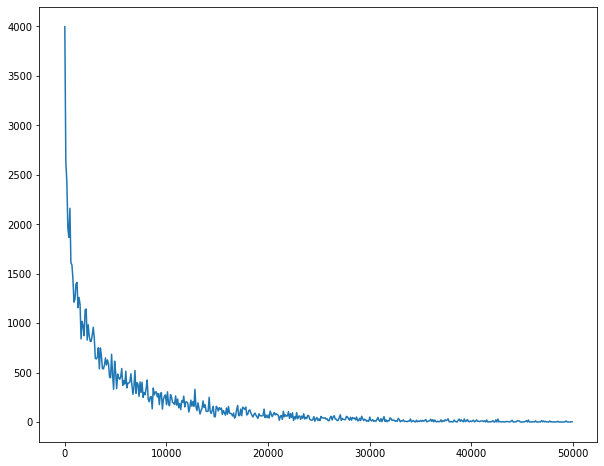

In [78]:
if __name__ == '__main__':
    
    ptb_data = DataPreproess(window_size=2,data_format = 'id',negative_sampling_size=4,negative_sampling_params =0.75,module= 'skip_gram')
    ptb_data.get_ptb_data()
    print(ptb_data.train_data.shape,'\ndown!')
    
    sg_model = SkipGram(ptb_data.corpus,ptb_data.word_to_id,ptb_data.id_to_word,ptb_data.co_matrix,weight_width=300,window_size=2,batch_size=1000)
    sg_model.train(ptb_data.train_data,iter=50000,lr=0.01)

In [92]:
#将训练好的模型写入pickle文件
import pickle

with open('chapter4_trained_ptb_skip_gram_model.pickle','wb') as f:
    pickle.dump(sg_model,f)
    print('pickle dump down!')

pickle dump down!


In [93]:
with open('chapter4_trained_ptb_skip_gram_model.pickle','rb') as f:
    model = pickle.load(f)
    print('pickle load down!')

pickle load down!


In [97]:
sg_model.layers['embedding1'].params['W']

array([[-0.51852357, -1.63232146, -0.20128639, ...,  0.29107702,
        -1.12156357,  0.96195488],
       [ 3.25388854, -1.22920727, -0.16872985, ...,  2.56879846,
        -0.14908005,  0.10458817],
       [ 0.84250966,  1.59138189, -0.13245826, ...,  0.80776642,
         1.19345538,  0.05179749],
       ...,
       [ 0.78327062, -1.48215117, -0.30895907, ...,  1.27973431,
         0.13287863,  0.33468735],
       [-0.47650139,  0.35102506, -0.50774876, ..., -0.95888461,
        -0.94946736, -1.16222081],
       [-0.64629925, -0.15392495, -0.17539903, ...,  0.87610187,
        -0.28083982, -0.73327278]])

In [98]:
model.layers['embedding1'].params['W']

array([[-0.51852357, -1.63232146, -0.20128639, ...,  0.29107702,
        -1.12156357,  0.96195488],
       [ 3.25388854, -1.22920727, -0.16872985, ...,  2.56879846,
        -0.14908005,  0.10458817],
       [ 0.84250966,  1.59138189, -0.13245826, ...,  0.80776642,
         1.19345538,  0.05179749],
       ...,
       [ 0.78327062, -1.48215117, -0.30895907, ...,  1.27973431,
         0.13287863,  0.33468735],
       [-0.47650139,  0.35102506, -0.50774876, ..., -0.95888461,
        -0.94946736, -1.16222081],
       [-0.64629925, -0.15392495, -0.17539903, ...,  0.87610187,
        -0.28083982, -0.73327278]])

In [ ]:
# #测试FeatEmbedding()类
# if __name__ == '__main__':
#     W =np.random.randn(5,5)
#     fe1 = Embedding(W)
#     X = [0,3,1]
#     dout = np.random.rand(3,5)
#     print('fe1.forward(X):\n',fe1.forward(X),'\n')
#     fe1.backward(dout)
#     print('fe1.params:\n',fe1.params,'\n')
#     print('dout:\n',dout,'\n')
#     print('fe1.grads:\n',fe1.grads)

In [ ]:
# #测试sigmoid类
# if __name__ == '__main__':
#     s= Sigmoid()
#     X = np.random.randn(3,5)
#     dout = np.random.randn(3,5)
#     print('X:\n',X,'\n')
#     print('dout:\n',dout,'\n')
#     print('s.forward(X):\n',s.forward(X),'\n')
#     print('s.backward(dout):\n',s.backward(dout),'\n')

In [ ]:
# #交叉熵损失测试
# if __name__ == '__main__':
#     tl = CrossEntropyError()
#     a=[0,1]
#     X = 0.5*np.random.choice(a,size=(10))+0.1
#     y = np.random.choice(a,size=(10))
#     print('X:\n',X,'\n')
#     print('y:\n',y,'\n')
#     print('tl.forward(X,y):\n',tl.forward(X,y),'\n')
#     print('tl.backward():\n',tl.backward(),'\n')

In [ ]:
# #测试EmbeddingDot()类
# if __name__ == '__main__':
#     W = np.random.randn(3,5)
#     X = np.random.randn(2,3)
#     y = [3,1]
#     dout = np.random.randn(2)
    
#     print('W\n',W,'\n')
#     print('X\n',X,'\n')
#     print('y\n',y,'\n')
#     print('dout\n',dout,'\n')
    
#     ed = EmbeddingDot(W)
#     print('ed.forward(X,y)\n',ed.forward(X,y),'\n')
#     print('ed.backward(dout)\n',ed.backward(dout),'\n')
#     print('dw:\n',ed.grads['W'],'\n')

In [ ]:
# #negative_sampling()负采样功能测试
# if __name__ == '__main__':
#     from chapter2 import s2c,c2m
#     input_str = 'you say goodbye and i say hello.'
#     corpus = s2c(input_str)
#     word_to_id = corpus['word_to_id']
#     id_to_word = corpus['id_to_word']
#     co_matrix = c2m(corpus)
#     corpus = corpus['corpus']
#     postive_target = [1,2,3,4,5]
#     sampling_result = negative_sampling(corpus,co_matrix,word_to_id,id_to_word,postive_target,negative_sampling_size=2)
#     print(sampling_result.items())

In [ ]:
# class Affine:
#     '''
#     一个带有偏置的全链接层，偏置默认是零
#     '''
#     def __init__(self,W,b=0):
        
#         self.params = {}
#         self.params['W'] = W
#         self.params['b'] = b
#         self.grads = {}
#         self.grads['W'] = np.zeros_like(self.params['W'])
#         self.grads['b'] = np.zeros_like(self.params['b'])
        
#     def forward(self,X):
        
#         self.params['X'] = X
        
#         return np.dot(X,self.params['W'])+self.params['b']
    
#     def backward(self,dout):
        
#         self.grads['W'] = np.dot(dout,self.params['X'].T)
#         self.grads['b'] = np.sum(dout,axis=0)
#         self.grads['X'] = np.dot(dout,self.params['W'].T)
        
#         return self.grads['X']

In [18]:
# class DataAverage():
    
#     def __init__(self):

#         self.params ={}
#         self.gards = {}
    
#     def forward(self,*arrays):
            
#         result = np.zeros_like(arrays[0])
        
#         for array in arrays:
            
#             result += array
        
#         result = result/len(arrays)
        
#         return result
    
#     def backward(self,dout,window_size):
        
#         return (1/window_size)*dout